# Importing Libraries
---

In [60]:
import tensorflow as tf
import pandas as pd
import numpy as np
import string
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# Exploring Data
---

In [33]:
df = pd.read_csv("./data/news-train.csv")

In [34]:
df

,ArticleId,Text,Category
0,1429,sfa awaits report over mikoliunas the scottish...,sport
1,1896,parmalat to return to stockmarket parmalat th...,business
2,1633,edu blasts arsenal arsenal s brazilian midfiel...,sport
3,2178,henman decides to quit davis cup tim henman ha...,sport
4,194,french suitor holds lse meeting european stock...,business
...,...,...,...
995,1250,blair damaged by blunkett row a majority of ...,politics
996,1639,a november to remember last saturday one news...,sport
997,916,highbury tunnel players in clear the football ...,sport
998,2217,top stars join us tsunami tv show brad pitt r...,entertainment


In [35]:
# Display the first few rows of the dataframe
print("First few rows of the dataframe:")
print(df.head())

First few rows of the dataframe:
   ArticleId                                               Text  Category
0       1429  sfa awaits report over mikoliunas the scottish...     sport
1       1896  parmalat to return to stockmarket parmalat  th...  business
2       1633  edu blasts arsenal arsenal s brazilian midfiel...     sport
3       2178  henman decides to quit davis cup tim henman ha...     sport
4        194  french suitor holds lse meeting european stock...  business


In [36]:
# Check for missing values
print("\nMissing values in the dataframe:")
print(df.isnull().sum())


Missing values in the dataframe:
ArticleId    0
Text         0
Category     0
dtype: int64


In [37]:
# Distribution of categories
print("\nDistribution of categories:")
print(df['Category'].value_counts())


Distribution of categories:
Category
sport            231
business         221
politics         186
tech             184
entertainment    178
Name: count, dtype: int64


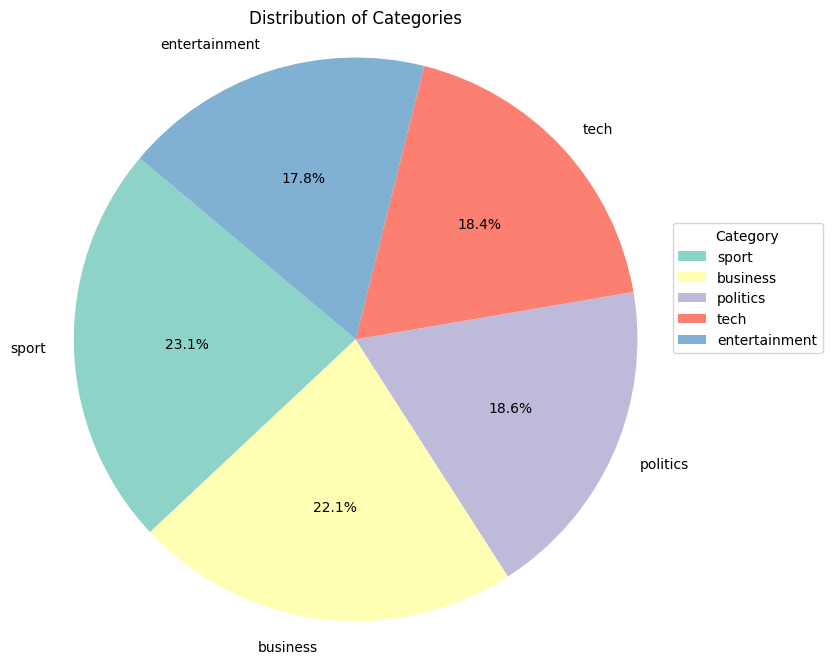

In [38]:
# Count the occurrences of each category
category_counts = df['Category'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3', len(category_counts)))
plt.title('Distribution of Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend outside the plot
plt.legend(title='Category', loc='upper left', labels=category_counts.index, bbox_to_anchor=(1, 0.7))

plt.show()

# Preprocessing Data
---

In [39]:
# Extracting text and labels
X = df['Text']
y = df['Category']

In [40]:
# Convert categorical labels to binary indicator variables using one-hot encoding
y = pd.get_dummies(y)

# Convert the one-hot encoded labels to numpy array for model training
y = np.asarray(y)

In [41]:
# Initialize and fit a Tokenizer object with a specified maximum number of words = len(word_index)+1
# First run this without num_words parameter and set max_words = len(word_index)+1. Then run it with the above mentioned condition
max_words = 21223

tokenizer = Tokenizer(num_words = 21223, lower = True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [42]:
# Convert text data to sequences of integers
sequences = tokenizer.texts_to_sequences(X)

In [43]:
# Pad sequences to ensure uniform length(by deafult pads at front)
data = pad_sequences(sequences)

In [44]:
# 80-20 Train-validation split
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size = 0.2, random_state=42)

# Load GloVE embeddings
---

In [45]:
# Define the path to the GloVe embeddings file
glove_directory = './glove/glove.6B.100d.txt'

# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

# Open the GloVe embeddings file and populate the embeddings dictionary
f = open(glove_directory, encoding ='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

# Print the number of word vectors found in the GloVe embeddings file
print(f"Found {len(embeddings_index)} word vectors. ")

Found 400000 word vectors. 


In [46]:
# Retrieve the embedding vector for any word from the embeddings_index dictionary, it's all lowercase
embeddings_index['happy']

array([-0.090436 ,  0.19636  ,  0.29474  , -0.47706  , -0.80436  ,
        0.3078   , -0.55205  ,  0.58453  , -0.17056  , -0.84846  ,
        0.19528  ,  0.23671  ,  0.46827  , -0.58977  , -0.12163  ,
       -0.24697  , -0.072944 ,  0.17259  , -0.0485   ,  0.9527   ,
        0.50629  ,  0.58497  , -0.19367  , -0.45459  , -0.031095 ,
        0.51633  , -0.24052  , -0.1007   ,  0.53627  ,  0.024225 ,
       -0.50162  ,  0.73692  ,  0.49468  , -0.34744  ,  0.89337  ,
        0.057439 , -0.19127  ,  0.39333  ,  0.21182  , -0.89837  ,
        0.078704 , -0.16344  ,  0.45261  , -0.41096  , -0.19499  ,
       -0.13489  , -0.016313 , -0.021849 ,  0.17136  , -1.2413   ,
        0.079503 , -0.91144  ,  0.35699  ,  0.36289  , -0.24934  ,
       -2.1196   ,  0.14534  ,  0.52964  ,  0.90134  ,  0.033603 ,
        0.022809 ,  0.70625  , -1.0362   , -0.59809  ,  0.70592  ,
       -0.072793 ,  0.67033  ,  0.52763  , -0.47807  , -0.67374  ,
        0.36632  , -0.38284  , -0.10349  , -0.6402   ,  0.1810

In [47]:
# Define the dimensionality of the word embeddings
embedding_dim = 100

# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((max_words, embedding_dim))

# Populate the embedding matrix with GloVe word embeddings for words in the word index,
# ensuring each word's embedding is assigned to the corresponding row in the matrix
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [48]:
# Determine the maximum length of sequences in the dataset
max_len = len(max(sequences, key=len))

# Neural Network Training
---

### Running 5 fold cross validation with 7 step learnign rates <br> [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

In [49]:
def nn_learningrate_variable(X, y):   
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True)
    
    results = []
    
    learning_rate = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
    
    for lr in learning_rate:
        lr_results = {"Learning Rate":lr, "Training Accuracies":[], "Validation Accuracies":[]}
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Define a Sequential model with an embedding layer
            model = Sequential()
            model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
            model.add(Flatten())
            model.add(Dense(32, activation='relu'))
            model.add(Dense(5, activation='softmax'))
            
            # Set the pre-trained GloVe word embeddings as weights for the Embedding layer
            model.layers[0].set_weights([embedding_matrix])

            # Freeze the weights of the Embedding layer to prevent training and retain the pre-trained embeddings
            model.layers[0].trainable = False
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            
            model.compile(optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy'])
            history = model.fit(X_train, y_train, epochs = 10, batch_size=16, validation_data=(X_val, y_val), verbose=0)
            
            t_loss, t_accuracy = model.evaluate(X_train, y_train, verbose=0)
            lr_results["Training Accuracies"].append(t_accuracy)
            v_loss, v_accuracy = model.evaluate(X_val, y_val, verbose=0)
            lr_results["Validation Accuracies"].append(v_accuracy)

        lr_results["Mean Training Accuracy"] = np.mean(lr_results["Training Accuracies"])
        lr_results["Mean Validation Accuracy"] = np.mean(lr_results["Validation Accuracies"])
        lr_results["Standard Deviation Training"] = np.std(lr_results["Training Accuracies"])
        lr_results["Standard Deviation Validation"] = np.std(lr_results["Validation Accuracies"])
        

        results.append(lr_results)
    
    return results

In [54]:
results_lr = nn_learningrate_variable(data, y)
lr_variation_df = pd.DataFrame(results_lr)

In [59]:
lr_variation_df

,Learning Rate,Training Accuracies,Validation Accuracies,Mean Training Accuracy,Mean Validation Accuracy,Standard Deviation Training,Standard Deviation Validation
0,0.0001,"[1.0, 1.0, 1.0, 1.0, 1.0]","[0.9100000262260437, 0.8999999761581421, 0.910...",1.00000,0.893,0.000000,0.031875
1,0.0003,"[0.9937499761581421, 1.0, 1.0, 1.0, 0.99874997...","[0.8849999904632568, 0.8700000047683716, 0.915...",0.99850,0.888,0.002424,0.016000
2,0.0010,"[0.9975000023841858, 0.9900000095367432, 0.998...","[0.8650000095367432, 0.7950000166893005, 0.819...",0.99425,0.840,0.005788,0.035496
3,0.0030,"[0.9850000143051147, 0.9449999928474426, 0.976...","[0.7350000143051147, 0.8199999928474426, 0.745...",0.92250,0.728,0.076848,0.055821
4,0.0100,"[0.7925000190734863, 0.45500001311302185, 0.67...","[0.6150000095367432, 0.4449999928474426, 0.465...",0.59550,0.450,0.134068,0.106207
5,0.0300,"[0.2775000035762787, 0.2512499988079071, 0.431...","[0.20000000298023224, 0.20999999344348907, 0.5...",0.29025,0.269,0.071490,0.123102
6,0.1000,"[0.22750000655651093, 0.22499999403953552, 0.2...","[0.23499999940395355, 0.25999999046325684, 0.1...",0.22950,0.212,0.013005,0.034728


### Observing the best averages from the graph, we pick the learning rate = 0.0001 

In [52]:
def nn_optimizer_variable(X, y):     
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True)
    results = []
    lr = 0.0001
    optimizers = ['sgd', 'rmsprop', 'adam']
    
    for o in optimizers:
        o_results = {"Optimiser":o, "Training Accuracies":[], "Validation Accuracies":[]}
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Define a Sequential model with an embedding layer
            model = Sequential()
            model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
            model.add(Flatten())
            model.add(Dense(32, activation='relu'))
            model.add(Dense(5, activation='softmax'))
            
            # Set the pre-trained GloVe word embeddings as weights for the Embedding layer
            model.layers[0].set_weights([embedding_matrix])

            # Freeze the weights of the Embedding layer to prevent training and retain the pre-trained embeddings
            model.layers[0].trainable = False
            
            if o == 'sgd':
                optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            if o == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
            if o == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            
            model.compile(optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy'])
            history = model.fit(X_train, y_train, epochs = 10, batch_size=16, validation_data=(X_val, y_val), verbose=0)
            
            t_loss, t_accuracy = model.evaluate(X_train, y_train, verbose=0)
            o_results["Training Accuracies"].append(t_accuracy)
            v_loss, v_accuracy = model.evaluate(X_val, y_val, verbose=0)
            o_results["Validation Accuracies"].append(v_accuracy)

        o_results["Mean Training Accuracy"] = np.mean(o_results["Training Accuracies"])
        o_results["Mean Validation Accuracy"] = np.mean(o_results["Validation Accuracies"])
        o_results["Standard Deviation Training"] = np.std(o_results["Training Accuracies"])
        o_results["Standard Deviation Validation"] = np.std(o_results["Validation Accuracies"])
        

        results.append(o_results)
    
    return results

In [53]:
results_optmizer = nn_optimizer_variable(data, y)
optimizer_variation_df = pd.DataFrame(results_optmizer)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
optimizer_variation_df

,Optimiser,Training Accuracies,Validation Accuracies,Mean Training Accuracy,Mean Validation Accuracy,Standard Deviation Training,Standard Deviation Validation
0,sgd,"[0.9100000262260437, 0.9162499904632568, 0.915...","[0.7799999713897705, 0.7049999833106995, 0.754...",0.90250,0.724,0.018557,0.038000
1,rmsprop,"[1.0, 1.0, 1.0, 1.0, 1.0]","[0.9150000214576721, 0.949999988079071, 0.8999...",1.00000,0.915,0.000000,0.019235
2,adam,"[1.0, 1.0, 1.0, 0.9987499713897705, 1.0]","[0.9100000262260437, 0.925000011920929, 0.8949...",0.99975,0.898,0.000500,0.017776


### Observing the best averages from the graph, we pick the optimiser = RMSprop

### Defining the /neural Network model with extracted parameter

In [63]:
# Define a Sequential model with an embedding layer
model = Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

# Set the pre-trained GloVe word embeddings as weights for the Embedding layer
model.layers[0].set_weights([embedding_matrix])

# Freeze the weights of the Embedding layer to prevent training and retain the pre-trained embeddings
model.layers[0].trainable = False

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer=optimizer,
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

# Define a ModelCheckpoint callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model with training data, specifying the ModelCheckpoint callback
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_100 (Embedding)       │ (None, 3356, 100)      │     2,122,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_100 (Flatten)           │ (None, 335600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │    10,739,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,861,697 (49.06 MB)

 Trainable params: 12,861,697 (49.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3982 - loss: 1.5622
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4036 - loss: 1.5517 - val_accuracy: 0.7100 - val_loss: 0.8724
Epoch 2/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9292 - loss: 0.4114
Epoch 2: val_accuracy did not improve from 0.71000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9297 - loss: 0.4095 - val_accuracy: 0.5100 - val_loss: 1.4310
Epoch 3/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9919 - loss: 0.1034
Epoch 3: val_accuracy improved from 0.71000 to 0.77500, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9919 - loss: 0.1030 - val_accuracy: 0.7750 - val_loss: 0.6588
Epoch 4/20
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0272
Epoch 4: val_accuracy improved from 0.77500 to 0.88500, saving model to best_model.ker